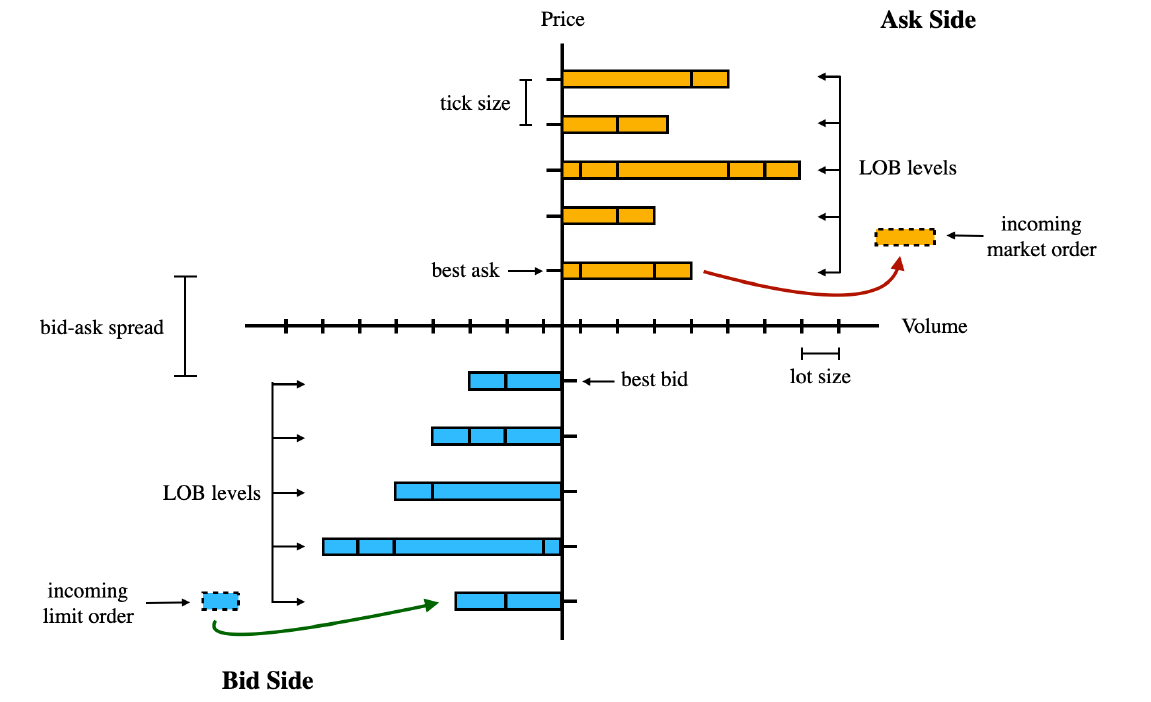

- 1. Go to https://lobsterdata.com/info/DataSamples.php and download the 10 level data for amazon and microsoft
- 2. Save in a folder named 'data' where this file is saved.


Data & Book: You can download the book "Trades, Quotes and Prices" by logging into Cambridge Univ. Press with your UCL credentials.
https://www.cambridge.org/core/books/trades-quotes-and-prices/029A71078EE4C41C0D5D4574211AB1B5
In the preface you can find the password to download a snapshot of the LOB for free: https://lobsterdata.com/
You can also access sample data of single stocks https://lobsterdata.com/info/DataSamples.php
Other data sources: https://www.dukascopy.com/trading-tools/widgets/quotes/historical_data_feed [1 level LOB data]

Other data (crypto): https://github.com/ccxt 


In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import numpy as np
from matplotlib.dates import DateFormatter
import os 
  
cwd=os.getcwd()

#The time component in the data is recorded in seconds after midnight.

startTrad = 9.5*60*60       # 9:30:00.000 in s after midnight
endTrad = 16*60*60        # 16:00:00.000 in s after midnight

# Message file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x 6)

  - Structure:    Each row:
                  Time stamp (sec after midnight with decimal
                  precision of at least milliseconds and
                  up to nanoseconds depending on the period),
                  Event type, Order ID, Size (# of shares),
                  Price, Direction

                  Event types:
                      - '1'   Submission new limit order
                      - '2'   Cancellation (partial)
                      - '3'   Deletion (total order)
                      - '4'   Execution of a visible limit order
                      - '5'   Execution of a hidden limit order
			- '7'   Trading Halt (Detailed 
                              information below)

                  Direction:
                      - '-1'  Sell limit order
                      - '1'  Buy limit order
                      - NOTE: Execution of a sell (buy)
                              limit order corresponds to
                              a buyer-(seller-) initiated
                              trade, i.e. a BUY (SELL) trade.

----------------------------------------------------------

This loads the data using Pandas. It filters for messages sent between 0930 and 1600.

In [4]:
def load_data(ticker='AMZN',time_format=False,startTrad=startTrad,endTrad=endTrad):

    theMessageBookFileName = ticker+"_2012-06-21_34200000_57600000_message_10.csv"  #change this if you load other samples
    #theMessageBookFileName=os.path.join(cwd,"data",theMessageBookFileName) #specify data location (in this case inside 'data' folder)


    theMessageBook = pd.read_csv(theMessageBookFileName, names = ['Time','Type','OrderID','Size','Price','TradeDirection'])

    #we will need this for filtering the orderbook data#
    theMessageBook['row_index']=theMessageBook.index.values

    theMessageBookFiltered = theMessageBook[theMessageBook['Time'] >= startTrad] 
    theMessageBookFiltered = theMessageBookFiltered[theMessageBookFiltered['Time'] <= endTrad]
    
    if time_format:
        theMessageBookFiltered=theMessageBookFiltered.set_index(pd.to_datetime(theMessageBookFiltered.Time,unit='s'))
    
    return theMessageBookFiltered

In [5]:
msg_book_amzn=load_data(ticker='AMZN',time_format=True)
msg_book_msft=load_data(ticker='MSFT',time_format=True)

In [6]:
# Q1: Check this has done what we think it should do. 
#Let's print the first rows and last rows of the dataframe.

print(msg_book_amzn.head())
print(msg_book_amzn.tail())
print(msg_book_msft.head())
print(msg_book_msft.tail())

                                       Time  Type   OrderID  Size    Price  \
Time                                                                         
1970-01-01 09:30:00.017459617  34200.017460     5         0     1  2238200   
1970-01-01 09:30:00.189607670  34200.189608     1  11885113    21  2238100   
1970-01-01 09:30:00.189607670  34200.189608     1   3911376    20  2239600   
1970-01-01 09:30:00.189607670  34200.189608     1  11534792   100  2237500   
1970-01-01 09:30:00.189607670  34200.189608     1   1365373    13  2240000   

                               TradeDirection  row_index  
Time                                                      
1970-01-01 09:30:00.017459617              -1          0  
1970-01-01 09:30:00.189607670               1          1  
1970-01-01 09:30:00.189607670              -1          2  
1970-01-01 09:30:00.189607670               1          3  
1970-01-01 09:30:00.189607670              -1          4  
                                       T

In [8]:
# Q2: How many events in this trading day for the two stocks?
print(f"The number of events in this trading day for AMZN is {len(msg_book_amzn)}")
print(f"The number of events in this trading day for MSFT is {len(msg_book_msft)}")

The number of events in this trading day for AMZN is 269748
The number of events in this trading day for MSFT is 668765


In [9]:
# Q3: up to which temporal precision do we get the data? (minute/seconds,etc.)
# We get the data to the precision of ~10^-9 seconds (look at time column)
# Note this is not a coding exam so don't need to write code to find this

In [25]:
# Q4: create a 'summary' function that aggregates events by type (cancellations, hidden/visible etc.) 
# and (1) counts them and (2) calculate the share of volume traded. Any observation?
def summary(msg_book):
    summary = msg_book.groupby("Type")["Size"].agg(["count", "sum"])
    summary /= summary.sum() # share of volume traded is a proportion
    return summary
print(msg_book_amzn.Size.sum()) #total volume
print(msg_book_msft.Size.sum()) #total volume

26130625
347108132


What is the distribution of events?

In [26]:
#   - '1'   Submission new limit order
#   - '2'   Cancellation (partial)
#   - '3'   Deletion (total order)
#   - '4'   Execution of a visible limit order
#   - '5'   Execution of a hidden limit order
def summary(msg_book):
    summary=msg_book.groupby('Type')['Size'].agg(['count','sum'])
    summary=summary/summary.sum()
    #summary['description']=summary.index.map({1:'New LO',2:'Cancel',3:'Deletion',4:'Execution visible',5:'Execution hidden'})
    return summary

In [37]:
#Q3: What does this function calculate?
#It counts the number of events of each type, volume per type through the sum, finds the proportion of total
#volume for each type and relative count and provides a description, matching the corresponding index to the event type
#Q4: Print a summary of all the events for the two stocks AMZ & MSFT
print(summary(msg_book_amzn))
print(summary(msg_book_msft))
print(msg_book_amzn.groupby('Type')['Size'].agg(['count','sum']).sum()) #total count and volume for all events (amzn)
print(msg_book_msft.groupby('Type')['Size'].agg(['count','sum']).sum()) #total count and volume for all events (msft)
#Q5: Which observations can we make about the occurrence of the different events?
#Submission and deletion of limit orders are the events that occur the most, note the difference between deletion and cancellation: cancellation can
#be partial. Deletion deletes the whole order.
#Event that occurs the least is execution of a hidden order.

         count       sum
Type                    
1     0.489175  0.498550
2     0.010814  0.013223
3     0.457679  0.457200
4     0.033268  0.023469
5     0.009064  0.007558
         count       sum
Type                    
1     0.492798  0.503541
2     0.008377  0.006280
3     0.448862  0.458995
4     0.044557  0.028486
5     0.005407  0.002699
count      269748
sum      26130625
dtype: int64
count       668765
sum      347108132
dtype: int64


Check for trading halts.

----------------------------------------------------------
When trading halts, a message of type '7' is written into the 
'message' file. The corresponding price and trade direction 
are set to '-1' and all other properties are set to '0'. 

Should the resume of quoting be indicated by an additional 
message in NASDAQ's Historical TotalView-ITCH files, another 
message of type '7' with price '0' is added to the 'message' 
file. Again, the trade direction is set to '-1' and all other 
fields are set to '0'.

When trading resumes a message of type '7' and 
price '1' (Trade direction '-1' and all other 
entries '0') is written to the 'message' file. 

For messages 
of type '7', the corresponding order book rows contain a 
duplication of the preceding order book state. The reason 
for the trading halt is not included in the output.

Example: Stylized trading halt messages in 'message' file.				

Halt: 			36023	| 7 | 0 | 0 | -1 | -1
                                    ...
Quoting: 		36323 	| 7 | 0 | 0 | 0  | -1
                                    ...
Resume Trading:		36723   | 7 | 0 | 0 | 1  | -1
                                    ...
The vertical bars indicate the different columns in the message file.


Check on Nasdaq historical trading halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHalts# and reason for halts http://www.nasdaqtrader.com/Trader.aspx?id=TradeHaltCodes

NYSE https://www.nyse.com/trade-halt-current

In [38]:
def check_for_halts(theMessageBookFiltered):

    # Note: As the rows of the message and orderbook file correspond to each other, the time index of
    # the message file can also be used to 'cut' the orderbook file.

    # Check for trading halts
    # ----------------------------------------------------------
    tradingHaltIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == -1) & (theMessageBookFiltered.TradeDirection == -1)]

    tradeQuoteIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 0)& (theMessageBookFiltered.TradeDirection == -1)]

    tradeResumeIdx = theMessageBookFiltered.index[(theMessageBookFiltered.Type == 7) & (theMessageBookFiltered.Price == 1)& (theMessageBookFiltered.TradeDirection == -1)]

    if (len(tradingHaltIdx) == 0 | len(tradeQuoteIdx) == 0  | len(tradeResumeIdx) == 0):
        print("No trading halts detected.")

    if(len(tradingHaltIdx) != 0):
        print("Data contains trading halt! at timestamp(s): "); print(list(tradingHaltIdx))

    if(len(tradeQuoteIdx) != 0):
        print(" Data contains quoting message! at timestamp(s)"); print(list(tradeQuoteIdx)) 

    if(len(tradeResumeIdx) != 0):
        print(" Data resumes trading! at timestamp(s) "); print(list(tradeResumeIdx))

In [39]:
#Q6: Chech whether any trading halt is recorded.
check_for_halts(msg_book_amzn)
check_for_halts(msg_book_msft)

No trading halts detected.
No trading halts detected.


# Plot - Number of Executions and Trade Volume by Interval
_____________________________________________________________________________
              
Note: Difference between trades and executions

   The LOBSTER output records limit order executions
   and not what one might intuitively consider trades (market orders).

   Imagine a volume of 1000 is posted at the best ask
   price. Further, an incoming market buy order of
   volume 1000 is executed against the quote.

   The LOBSTER output of this trade depends on the
   composition of the volume at the best ask price.
   Take the following two scenarios with the best ask
 	 volume consisting of ...
   	(a) 1 sell limit order with volume 1000
   	(b) 5 sell limit orders with volume 200 each
      	(ordered according to time of submission)

    The LOBSTER output for case ...
      (a) shows one execution of volume 1000. If the
          incoming market order is matched with one
          standing limit order, execution and trade
          coincide.
      (b) shows 5 executions of volume 200 each with the
          same timestamp. The incoming order is matched
          with 5 standing limit orders and triggers 5
          executions.
          
  --> When the data does not contain errors, these events occur at the same time t (same side of the LOB): by grouping them all together one can reconstruct the volume of the incoming market order. In general though, HF data contains errors and reconstructing MOs from raw data is non-trivial.

  Bottom line:
      LOBSTER records the exact limit orders against
      which incoming market orders are executed. Trade size has to be
      inferred from the executions.
     

In [40]:
#Q7 Generate a plot showing the number and size of visible and invisible executions for the two stocks

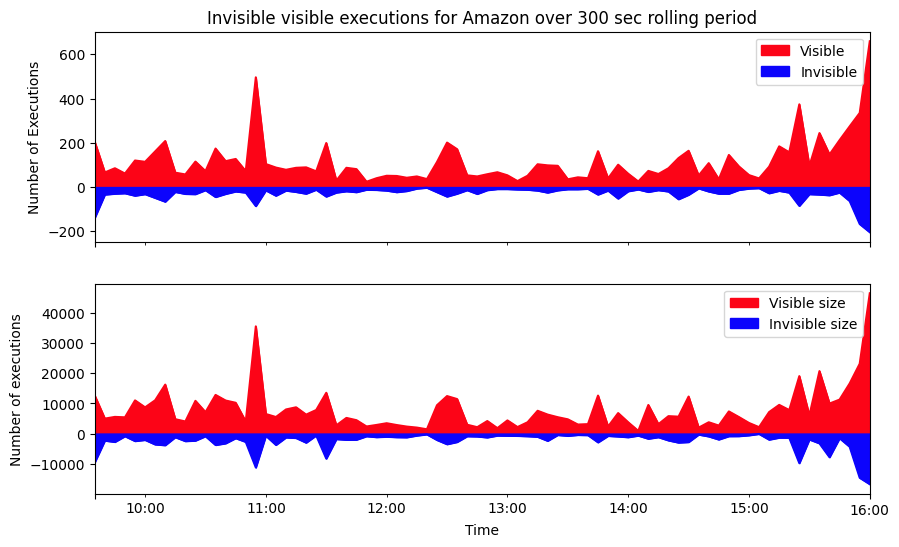

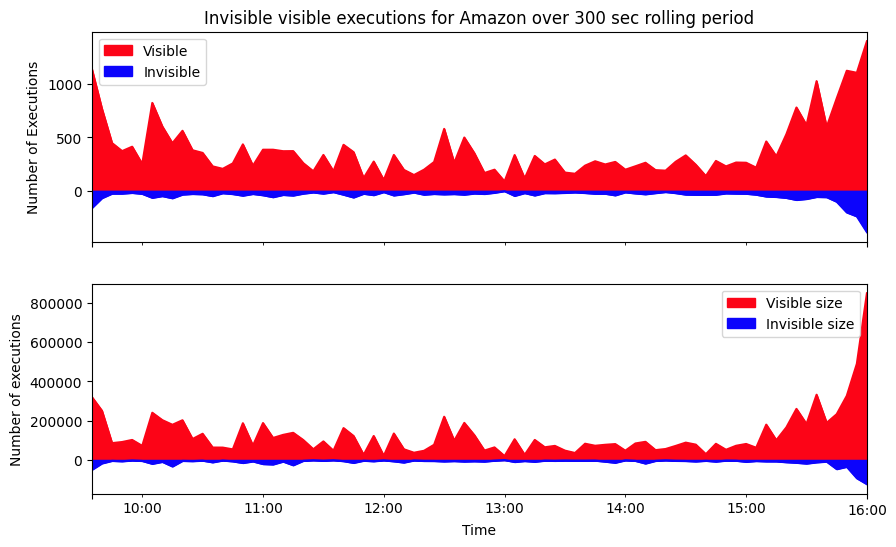

In [41]:
def visible_invisible_plot(df_in,ticker,rolling_seconds=300):
    #note ticker is for example "Amazon" or "Microsoft"
    #to resample we need to set index to a time index
    try:
        assert type(df_in.index)==pd.core.indexes.datetimes.DatetimeIndex
        
    except AssertionError:
        df=df_in.set_index(pd.to_datetime(df_in.Time,unit='s'))
    df=pd.DataFrame(df_in)
        
    #only select the trade executions (type 4 & 5)
    
    df = df[df.Type.isin([4,5])]


    #separate out the data of interest into separate columns for size and number of executions, use fact that true =1 and  false=0
    
    df['Visible']=df.Type==4 # boolean column
    df['Visible size']=df['Visible']*df['Size'] # find sizes for those that are indeed visible, show size 0 for non-visible so they don't show up on plot

    df['Invisible']=-1*(df.Type==5) #-1 multiplier to flip hidden trades on x axis, to allow us to differentiate them visually
    df['Invisible size']=df['Invisible']*df['Size']

    #resample data into 5 minute intervals, sum contents of each time bucket.
    resampled_data=df.resample(str(rolling_seconds)+'S',label='right').sum()
    # label = 'right' makes bucket label the same as right edge for bucket
    
    #create a subplot with two axes which shares the x -time axis
    fig,axs=plt.subplots(2,1,sharex=True,figsize=(10,6))
    # 2 rows, 1 column, big fig
    # axs[0] is first set of axes (used for first graph), axs[1] is second set of axes (used for second graph)

    #using the plotting backend in pandas (pyplot by default)
    resampled_data[['Visible','Invisible']].plot(ax=axs[0],kind='area',color = ('#fc0417','#0c04fc'))
    # plot the first set of axes for first graph
    axs[0].set_ylabel('Number of Executions')

    resampled_data[['Visible size','Invisible size']].plot(ax=axs[1],kind='area',color = ('#fc0417','#0c04fc'))
    # plot the second set of axes for second graph
    axs[1].set_ylabel('Number of executions')

    axs[0].set_title(f'Invisible visible executions for {ticker} over {str(rolling_seconds)} sec rolling period')

    return resampled_data

rsd_amzn=visible_invisible_plot(msg_book_amzn,"Amazon")
rsd_msft=visible_invisible_plot(msg_book_msft,"Amazon")
# we want to insert our dataframes, using tickers "Amazon" or "Microsoft" for corresponding df

Now we are going to look at the order book data.

# Orderbook file information:
----------------------------------------------------------

  - Dimension:    (NumberEvents x (NumberLevels*4))

  - Structure:    Each row:
                  Ask price 1, Ask volume 1, Bid price 1,
                  Bid volume 1, Ask price 2, Ask volume 2,
                  Bid price 2, Bid volume 2, ...

  - Note:         Unoccupied bid (ask) price levels are
                  set to -9999999999 (9999999999) with volume 0.
				      
----------------------------------------------------------

In [44]:
def loadOrderBook(theMessageBook,ticker='AMZN'):
    #_____________________________________________________________________________
    #
    # Load Order Book File
    # This is going to output a dictionary of four dataframes - asks/bids prices/sizes
    #It will be indexed by the time index formed from the messagebook df
    #_____________________________________________________________________________
    nlevels = 10 #change number of levels

    # Load data
    theOrderBookFileName = ticker+"_2012-06-21_34200000_57600000_orderbook_10.csv"
    #theOrderBookFileName=os.path.join(cwd,"data",theOrderBookFileName)
    print(theOrderBookFileName)

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']
    theNames=[str(col_name)+str(level_no)  for level_no in range(1,nlevels+1) for col_name in col ]

    theOrderBook = pd.read_csv(theOrderBookFileName, names = theNames)
        
    #timeIndex = theMessageBook.index[(theMessageBook.Time >= startTrad) & (theMessageBook.Time <= endTrad)]
    #theOrderBookFiltered = theOrderBook[theOrderBook.index == timeIndex]
        
    theOrderBookFiltered = theOrderBook.iloc[theMessageBook.row_index]
    
    #theOrderBookFiltered=theOrderBookFiltered.set_index(pd.to_datetime(theMessageBook.Time,unit='s'))
    theOrderBookFiltered=theOrderBookFiltered.set_index(theMessageBook.index)
    
    # Convert prices into dollars
    #    Note: LOBSTER stores prices in dollar price times 10000

    col = ['Ask Price ','Ask Size ','Bid Price ','Bid Size ']

    #separate the four types of column into a dictionary with key=column type
    data_col_dic={c.strip():[c+str(level_no)  for level_no in range(1,nlevels+1)] for c in col}

    #separate data into four aligned dataframes of the four different types of data with key=data type
    data_dic={c:theOrderBookFiltered[cols] for c,cols in data_col_dic.items()}
      
    return data_dic

In [45]:
OB_dic_amzn=loadOrderBook(msg_book_amzn,ticker='AMZN')

OB_dic_msft=loadOrderBook(msg_book_msft,ticker='MSFT')

AMZN_2012-06-21_34200000_57600000_orderbook_10.csv
MSFT_2012-06-21_34200000_57600000_orderbook_10.csv


The output is a dictionary of dataframes. Each row of this dataset should refer to the orderbook state after a new event has happened. So it should be the same length. Let us check that.

In [46]:
def data_checker(OB_dic,msg_book):

    for k,val in OB_dic.items():
        
        assert val.shape[0]==msg_book.shape[0]
        print("ok!",k,type(val),val.shape)
    
data_checker(OB_dic_amzn,msg_book_amzn)
data_checker(OB_dic_msft,msg_book_msft)

ok! Ask Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (269748, 10)
ok! Ask Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Ask Size <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Price <class 'pandas.core.frame.DataFrame'> (668765, 10)
ok! Bid Size <class 'pandas.core.frame.DataFrame'> (668765, 10)


In [50]:
#Q6: check the structure of the data
print(OB_dic_amzn)
print(OB_dic_msft)
#Q7: Compute bid, ask , mid-price, spread associated with each event.
bid_prices=OB_dic_amzn['Bid Price']
ask_prices=OB_dic_amzn['Ask Price']
print(bid_prices)
print(ask_prices)

spread_1=ask_prices['Ask Price 1']- bid_prices['Bid Price 1'] # ask - bid
gapA= -ask_prices['Ask Price 1']+ask_prices['Ask Price 2'] # ask2 - ask1
gapB= bid_prices['Bid Price 1']-bid_prices['Bid Price 2'] # bid1 - bid2
mid =(ask_prices['Ask Price 1']+ bid_prices['Bid Price 1'])/2 # (ask + bid)/2
print(mid)

{'Ask Price':                                Ask Price 1  Ask Price 2  Ask Price 3  \
Time                                                                   
1970-01-01 09:30:00.017459617      2239500      2239900      2240000   
1970-01-01 09:30:00.189607670      2239500      2239900      2240000   
1970-01-01 09:30:00.189607670      2239500      2239600      2239900   
1970-01-01 09:30:00.189607670      2239500      2239600      2239900   
1970-01-01 09:30:00.189607670      2239500      2239600      2239900   
...                                    ...          ...          ...   
1970-01-01 15:59:59.872741285      2206200      2206400      2206500   
1970-01-01 15:59:59.903989046      2206400      2206500      2206700   
1970-01-01 15:59:59.955241980      2206400      2206500      2206700   
1970-01-01 15:59:59.958244616      2206300      2206400      2206500   
1970-01-01 15:59:59.959359650      2206400      2206500      2206700   

                               Ask Price 4  Ask P

In [51]:
def order_book_look(OB_dic,ticker,random_no=None):
    # Note: Pick a random row/event from the order book if not specified
    
    if random_no is None:
        random_no = OB_dic['Bid Size'].sample().index[0]
    else:
        #first appearing event after the given time
        random_no=OB_dic['Bid Size'][OB_dic['Bid Size'].index>random_no].index[0]
      
    time=random_no.strftime('%H:%M:%S:%f')

    #
    # Plot 1 - Snapshot of the Limit Order Book
    #_____________________________________________________________________________

    fig,ax=plt.subplots(2,1,figsize=(9,9)) 

    bid_data=OB_dic['Bid Size'].loc[random_no]
    bid_prices=OB_dic['Bid Price'].loc[random_no]

    ask_data=OB_dic['Ask Size'].loc[random_no]
    ask_prices=OB_dic['Ask Price'].loc[random_no]

    # for first set of axes, ax[0]
    ax[0].bar(ask_prices/10000,ask_data,
           width=0.007, color='#fc1b04', label='Ask')   # Divide price by 10000 to get price in dollars
    ax[0].bar(bid_prices/10000,bid_data,
           width=0.007,color='#13fc04', label='Bid')

    ax[0].set_ylabel('Quantity')
    ax[0].set_xlabel('Price($)')
    ax[0].set_title(f'Order book at {str(time)} for {ticker}')
    
    #Q8: add plot of DEPTH PROFILE
    #_____________________________________________________________________________
    #
    # Plot 2 - Relative Depth in the Limit Order Book
    #_____________________________________________________________________________
    # Plot variables
    # for second set of axes, ax[1]
    ax[1].step(range(1,11,1),bid_data.cumsum()/bid_data.sum(),label='Bid',color='#13fc04') # sums up to current size, divides by total size
    ax[1].step(range(1,11,1),-1*ask_data.cumsum()/ask_data.sum(),label='Ask',color='#fc1b04') # -1 multiplier for better visual

    ax[1].set_ylim(-1,1)
    ax[1].set_xlim(1,10)
    #ax[1].set_title('Relative Depth in the Limit Order Book for ' + ticker + ' at ' + str(time))
    ax[1].set_ylabel('% Orderbook')
    ax[1].set_xlabel('Level')
    
    return random_no

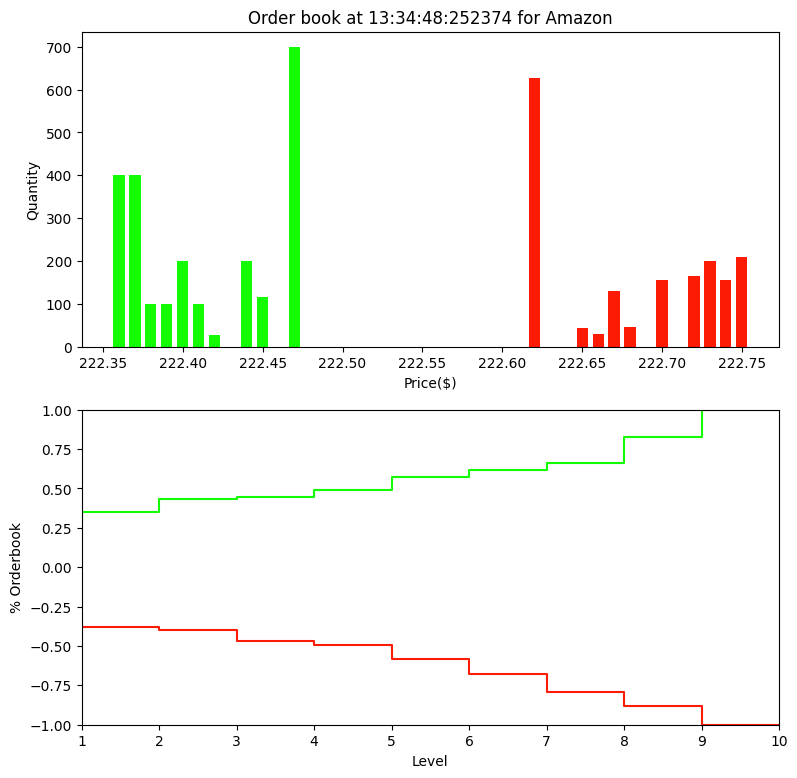

In [52]:
time=order_book_look(OB_dic_amzn,'Amazon')

Timestamp('1970-01-01 13:34:48.257906824')

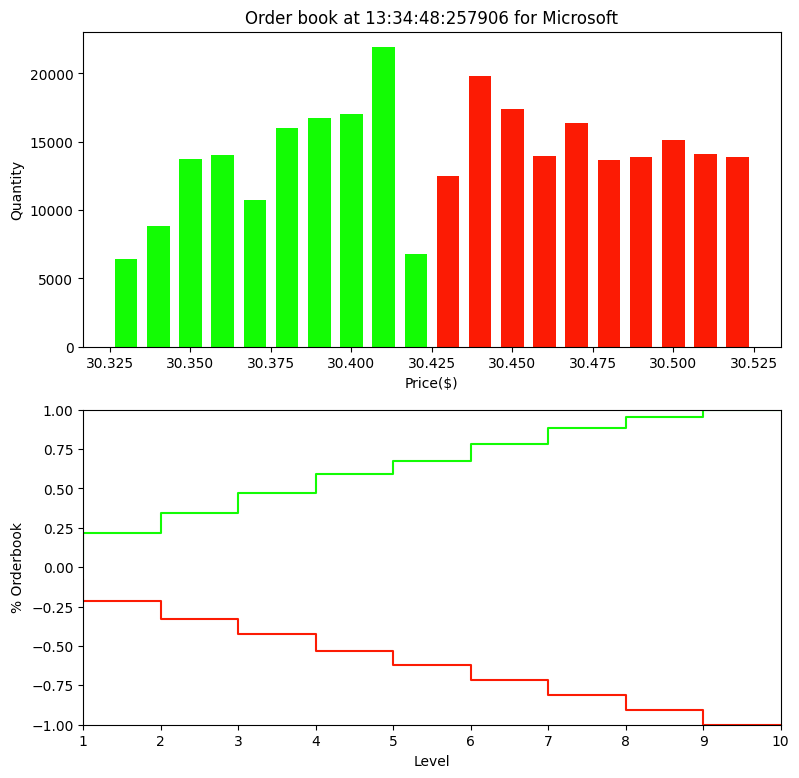

In [53]:
order_book_look(OB_dic_msft,'Microsoft',time)

# Event time vs time time

Event time is expressed as the sequence of events that occur in the limit order book. Sometimes it is convenient to think about of this as time instead of 'normal time'. 

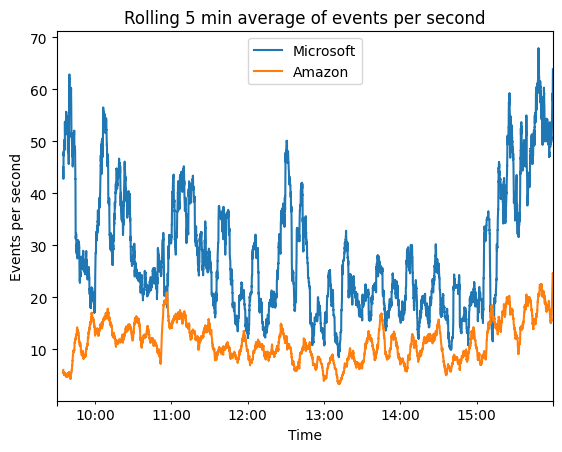

In [54]:
ax=msg_book_msft.resample("1S").count()['Time'].rolling(300).mean().plot(label='Microsoft',legend=True)
msg_book_amzn.resample("1S").count()['Time'].rolling(300).mean().plot(label='Amazon',legend=True,ax=ax,title='Rolling 5 min average of events per second')
_=ax.set_ylabel('Events per second')

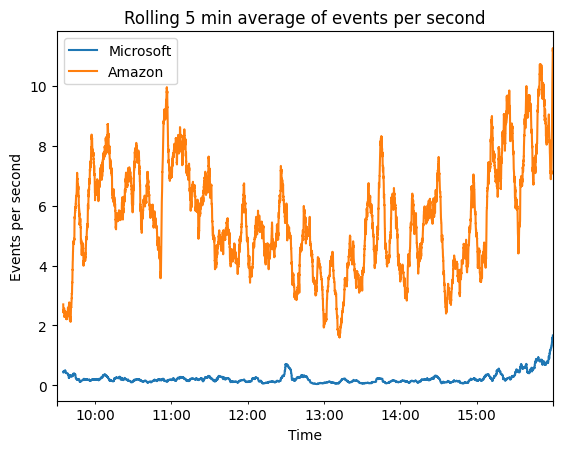

In [56]:
#Q9:Rolling average of events (all types of events here) per second...try selecting only a sub-type (e.g. only executions)
ax=msg_book_msft[msg_book_msft.Type==2].resample("1S").count()['Time'].rolling(300).mean().plot(label='Microsoft',legend=True)
msg_book_amzn[msg_book_amzn.Type==1].resample("1S").count()['Time'].rolling(300).mean().plot(label='Amazon',legend=True,ax=ax,title='Rolling 5 min average of events per second')
_=ax.set_ylabel('Events per second')

# Empirical properties of the LOB - large and small tick stocks

Now we are going to look at how a large tick stock - Microsoft differs from a small tick stock - Amazon.

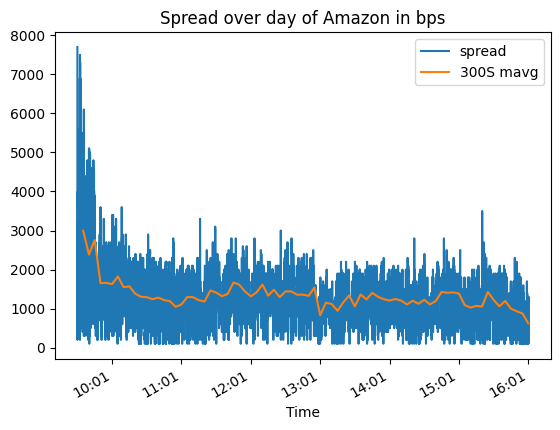

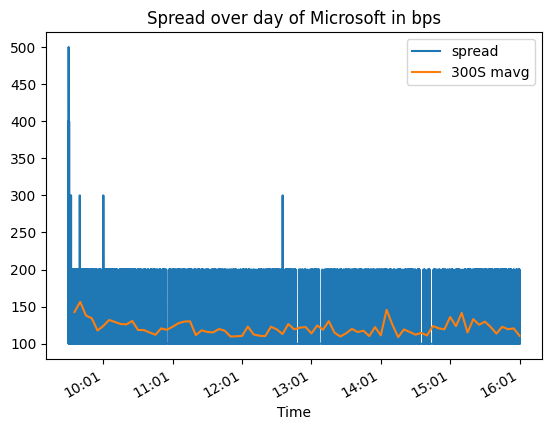

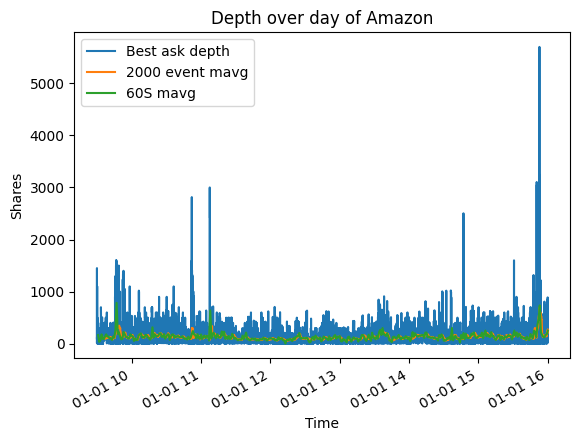

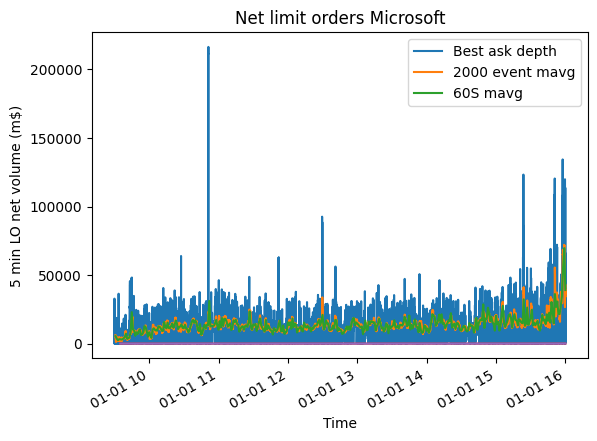

In [57]:
#Q10 Plot the spread and its moving average(over a period of 300s).
#Q11 Plot the depth at best and its moving average(over a period of 300s).

def spread_plot(OB_dic,ticker,rolling_unit=2000):
    #This plots the spread at best varies over the day.

    spread=pd.DataFrame((OB_dic['Ask Price']['Ask Price 1']-OB_dic['Bid Price']['Bid Price 1']),columns=['spread'])
    #spread['normalised_spread_bps']=10000*0.5*spread['spread']/(OB_dic['Ask Price']['Ask Price 1']+OB_dic['Bid Price']['Bid Price 1'])

    
    ax=spread.plot()
    
    spread_res=spread.resample(str(rolling_unit)+'S',label='right').mean()
    spread_res.columns=[str(rolling_unit)+'S mavg']
    spread_res.plot(ax=ax,legend=True)
    
    ax.set_title(f'Spread over day of {ticker} in bps')
    
    myFmt=DateFormatter("%H:%m")
    ax.xaxis.set_major_formatter(myFmt)
    return spread

df=spread_plot(OB_dic_amzn,'Amazon',rolling_unit=300)
df=spread_plot(OB_dic_msft,'Microsoft',rolling_unit=300)

def depth_at_best_plot(OB_dic,ticker,events=2000,resample_per=300):
    
    
    depth=pd.DataFrame(OB_dic['Ask Size']['Ask Size 1'])
    depth.columns=['Best ask depth']
    
    #average of last 2000 quotes - might not be time consistent
    
    depth[str(events)+ ' event mavg']=depth.rolling(events).mean()
    ax=depth.plot()
    
    res_per=str(resample_per)+'S'
    depth_res=depth.resample(res_per,label='right').mean()
    depth_res.columns=[res_per+ ' mavg','_']
    depth_res[res_per+ ' mavg'].plot(ax=ax,legend=True)

    ax.set_title(f'Depth over day of {ticker}')
    ax.set_ylabel('Shares')
    
    return depth_res

df=depth_at_best_plot(OB_dic_amzn,'Amazon',events=2000,resample_per=60)
df=depth_at_best_plot(OB_dic_msft,'Microsoft',events=2000,resample_per=60)

def plot_net_limit_orders(msg_book,ticker):

    #filter out executions to leave LOs, cancels and deletes
    net_limit_orders=msg_book[msg_book.Type.isin([1,2,3])]
    
    net_limit_orders=net_limit_orders.set_index(pd.to_datetime(net_limit_orders.Time,unit='s'))
    
    #create a column =1 if a LO and  -1 if a delete cancel
    net_limit_orders['accrete_deplete']=net_limit_orders.Type.map({1:1,2:-1,3:-1})
    #multiply with quantity to get signed LO quantity
    net_limit_orders['signed_size']=net_limit_orders['accrete_deplete']*net_limit_orders['Size']
    #    Note: LOBSTER stores prices in dollar price times 10000
    net_limit_orders['signed_volume']=net_limit_orders['signed_size']*net_limit_orders['Price']/10000

    #resample time series into 5 minute intervals, sum over each 5 minutes, units of US$m and plot
    ax=(net_limit_orders.signed_volume.resample('300S',label='right').sum()/1000000).plot()
    ax.set_title(f"Net limit orders {ticker}")
    ax.set_ylabel('5 min LO net volume (m$)')

plot_net_limit_orders(msg_book_amzn,"Amazon")
plot_net_limit_orders(msg_book_msft,"Microsoft")

# Event rates in the LOB

In [27]:
#get all of the LO submissions

def abs_dist(price,side,best_ask,best_bid):
    #little function to get absolute distance to best depending on order type
    if side==1:
        return best_bid-price
    elif side==-1:
        return price-best_ask



def event_rate(msg_book,OB_dic,Type=1):
    events=msg_book[msg_book.Type.isin([1])]
    
    #get the raw information we need from the Orderbook (Best bid and ask events)
    Best_state=pd.DataFrame({'Best_bid':OB_dic['Bid Price']['Bid Price 1'],
                             'Best_ask':OB_dic['Ask Price']['Ask Price 1']})
    
    #we want to know the state of the order book before submission of an order
    Best_state['prev_Best_bid']=Best_state.Best_bid.shift(1)
    Best_state['prev_Best_ask']=Best_state.Best_ask.shift(1)
    Best_state.fillna(0,inplace=True)

    #not necessary but this column return true if the best bid/ask has improved
    Best_state['Bid_improved']=Best_state['Best_bid']>Best_state['prev_Best_bid']
    Best_state['Ask_improved']=Best_state['Best_ask']<Best_state['prev_Best_ask']
    
    #merge the order book information with the message information    
        #events=events.merge(Best_state.iloc[events.row_index],left_on='row_index',right_on='row_index')
    #prefer concat because we know the rows are aligned. merge may get into trouble for simultaneous events.
    events=pd.concat([events,Best_state.iloc[events.row_index]],sort=False,axis=1)
    
    #apply absolute distance calculation row by row. 
    #This is slow way to do it but 
    events['abs_dist']=events.apply(lambda x: abs_dist(x['Price'],x['TradeDirection'],x['prev_Best_ask'],
                                                       x['prev_Best_bid']),axis=1 )
    
    
    
    return events


This is this the distribution of LO submissions wrt their absolute distance from best.

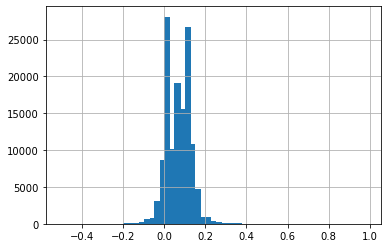

In [81]:
events_amzn=event_rate(msg_book_amzn,OB_dic_amzn,1)
(events_amzn['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

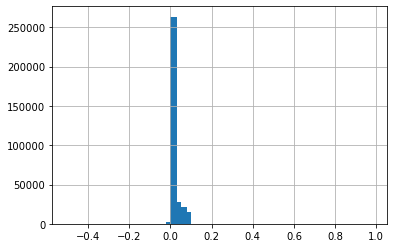

In [82]:
events_msft=event_rate(msg_book_msft,OB_dic_msft,1)
(events_msft['abs_dist']/10000).hist(bins=np.arange(-.5,1,0.025).round(2))

Note that there are LOs with negative absolute distance? These are best improving orders (bid above best or ask below)

In [83]:
bi=(events_msft.Bid_improved | events_msft.Ask_improved).value_counts()
bi/bi.sum()

False    0.993843
True     0.006157
dtype: float64

In [84]:
bi=events_amzn.Bid_improved.value_counts()
bi/bi.sum()

False    0.949899
True     0.050101
Name: Bid_improved, dtype: float64